In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import express as px
import warnings
warnings.simplefilter("ignore")
plt.style.use("fivethirtyeight")
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Reading in the data
events = pd.read_csv("data/events.csv")
matches = pd.read_csv("data/ginf.csv")

In [3]:
# Checking structure of the data
print(events.info())
print(matches.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941009 entries, 0 to 941008
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_odsp        941009 non-null  object 
 1   id_event       941009 non-null  object 
 2   sort_order     941009 non-null  int64  
 3   time           941009 non-null  int64  
 4   text           941009 non-null  object 
 5   event_type     941009 non-null  int64  
 6   event_type2    214293 non-null  float64
 7   side           941009 non-null  int64  
 8   event_team     941009 non-null  object 
 9   opponent       941009 non-null  object 
 10  player         880009 non-null  object 
 11  player2        291310 non-null  object 
 12  player_in      51715 non-null   object 
 13  player_out     51738 non-null   object 
 14  shot_place     227459 non-null  float64
 15  shot_outcome   228498 non-null  float64
 16  is_goal        941009 non-null  int64  
 17  location       467067 non-nul

The data is divided between two tables: one containing match details and the other capturing specific match events. To proceed with this report, I want to include the `league` and `season` columns in the *events* table. We can achieve this by merging the two tables based on the shared `id_odsp` column.

In [4]:
events = pd.merge(events, matches[["id_odsp","league","season"]], on="id_odsp", how="left")

In [5]:
# Data manipulation
events['is_goal'] = events['is_goal'].astype(bool)
events['bodypart'] = events['bodypart'].astype('category')
events['assist_method'] = events['assist_method'].astype('category')
events['id_odsp'] = events['id_odsp'].astype('str')
events['league'] = events['league'].astype('category')

matches['league'] = matches['league'].astype('category')
matches['season'] = matches['season'].astype('category')

In [6]:
# Replacing league levels with more common names
league_mapping = {'D1': 'Bundesliga', 'E0': 'Premier League', 'F1': 'Ligue 1', 'I1': 'Serie A', 'SP1': 'La Liga'}
events['league'] = events['league'].replace(league_mapping)
matches['league'] = matches['league'].replace(league_mapping)

In [7]:
# Filtering by advanced statistics 
filtered_matches = matches[matches['adv_stats'] == False]

# Select the 'league' and 'season' columns
subset = filtered_matches[['league', 'season']]

# Generate summary statistics
summary = subset.describe(include='all')

print(summary.transpose())

       count unique             top freq
league   930      5  Premier League  820
season   930      3            2012  446


In [8]:
# print(subset.league.value_counts())
print(subset.season.value_counts())

season
2012    446
2013    390
2014     94
2015      0
2016      0
2017      0
Name: count, dtype: int64


We notice the majority of matches that have no advanced statistics are from Premier league, and all of them between the years 2012 and 2014. 
To ensure fairness and credibility when comparing across leagues and teams, lets exclude all match events from those seasons.

In [9]:
# Filtering events for seasons after 2014
events = events[events['season'] > 2014]

# Section 1: Leagues
In this section, We will extract some key statistics about Europe’s top five leagues and see how they compare to each other.

### It's All About the Goals  
We'll begin by identifying which league scored the most goals. To ensure a fair comparison, I'll focus on the ratio of goals per match, given that the Bundesliga has two fewer teams than the other leagues. I'll also include the ratio of goals per shot to get a sense of each league's conversion rates.

In [10]:
# Calculating total goals
matches["goals"] = matches["fthg"] + matches["ftag"] 

In [11]:
# Total goals per league
goals_per_league = matches.groupby('league')["goals"].sum().reset_index()
# number of matches per league
number_of_matches = matches.groupby("league").size().reset_index(name='number_of_matches')
# Total shots/ attempts per league
shots = events[events["event_type"]==1].groupby('league').size().reset_index(name="shots")

In [12]:
ratios_table = pd.merge(number_of_matches, goals_per_league, on='league')
ratios_table['goals_per_match'] = ratios_table['goals'] / ratios_table['number_of_matches']
#ratios_table = pd.merge(ratios_table, shots, on="league")
ratios_table['goals_per_shot'] = ratios_table['goals'] / shots['shots']

In [13]:
ratios_table = ratios_table.sort_values('goals_per_match', ascending=False)

In [14]:
# Apply formatting
styled_ratios_table = (
    ratios_table.style.format(precision=2).set_properties(**{'text-align': 'left'})
    .bar(subset=['number_of_matches'], color='deepskyblue')
    .bar(subset=['goals'], color='lightgreen')
    .bar(subset=['goals_per_match'], color='orange')
    .bar(subset=['goals_per_shot'], color='magenta')
)

# Display the styled table (for Jupyter Notebook or output to HTML)
styled_ratios_table

,league,number_of_matches,goals,goals_per_match,goals_per_shot
0,Bundesliga,1690,4871,2.88,0.26
4,La Liga,2089,5787,2.77,0.27
1,Premier League,2120,5812,2.74,0.23
3,Serie A,2106,5580,2.65,0.22
2,Ligue 1,2107,5283,2.51,0.24


It seems that across all five leagues, the average is around 2-3 goals per match. Although the Bundesliga had the lowest total number of goals, it boasted the highest goals-per-match rate, highlighting the importance of using ratios instead of just absolute numbers. On the other hand, La Liga achieved the highest conversion rate, with over one in four shots resulting in a goal.

### Rough Play  
Now, let's dive into the statistics for bookings and send-offs across each league. Serie A is often considered Europe’s "roughest" league—let's find out if the numbers support this reputation.

In [15]:
cards = events[(events["event_type"]==4) | (events["event_type"]==5) | (events["event_type"]==6)].groupby("league").size().reset_index(name="total_cards")

In [16]:
cards["cards_per_match"] = cards.total_cards / number_of_matches.number_of_matches

In [17]:
cards = cards.sort_values("cards_per_match", ascending=False)
cards

,league,total_cards,cards_per_match
4,La Liga,5110,2.45
3,Serie A,5042,2.39
2,Ligue 1,3718,1.76
0,Bundesliga,2942,1.74
1,Premier League,3605,1.70


Text(0, 0.5, 'League')

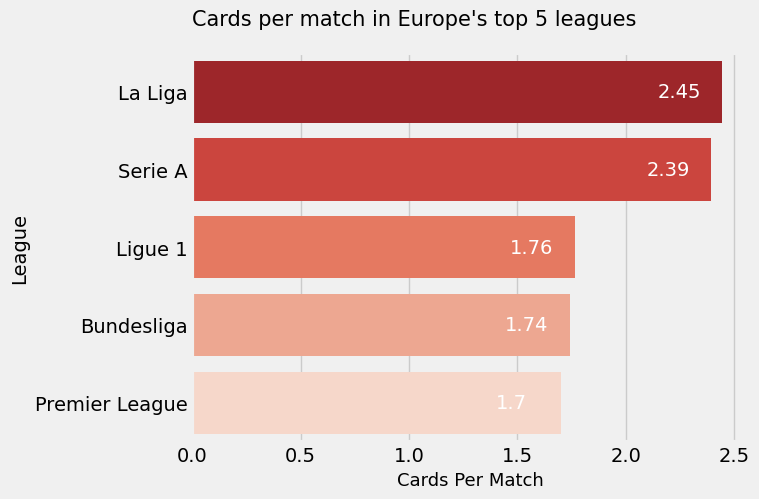

In [18]:
ax = sns.barplot(data=cards, x="cards_per_match", y="league",  palette='Reds_r', order=cards.league)

for index, value in enumerate(cards['cards_per_match']):
    plt.text(value - 0.3, index , f'{round(value,2)}', color='white', ha='left', va='center')

plt.title("Cards per match in Europe's top 5 leagues", fontsize=15, pad=20, loc='left')
plt.xlabel('Cards Per Match', fontsize=13)
plt.ylabel('League', fontsize=14)


Fascinating! This suggests that La Liga and Serie A might truly be the 'roughest' leagues, or perhaps their referees are simply quicker to reach for their cards when fouls occur. Let's dig deeper by examining the number of fouls across each league.

In [19]:
fouls = events[(events["event_type"]==3)].groupby("league").size().reset_index(name='total_fouls')

In [20]:
cards["fouls_per_match"] = fouls.total_fouls / number_of_matches.number_of_matches

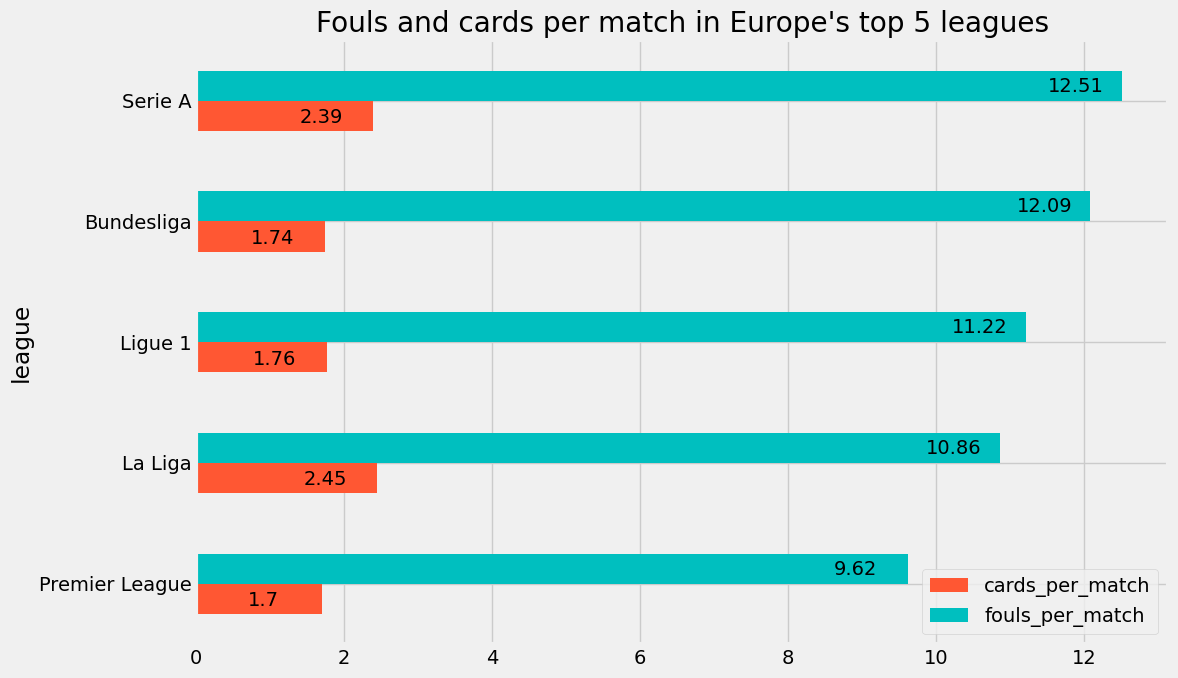

In [21]:
cards_reindexed = cards.sort_values('fouls_per_match').set_index("league")[["cards_per_match","fouls_per_match"]]

ax = cards_reindexed.plot(kind="barh",
                          color=['#FF5733','c'],
                          figsize=(12, 7))

for index, value in enumerate(cards_reindexed['fouls_per_match']):
    plt.text(value - 1, index + 0.12, f'{round(value,2)}', color='black', ha='left', va='center')

for index, value in enumerate(cards_reindexed['cards_per_match']):
    plt.text(value - 1, index - 0.14, f'{round(value,2)}', color='black', ha='left', va='center')

plt.title("Fouls and cards per match in Europe's top 5 leagues")
plt.tight_layout()

This plot reveals that Serie A games do indeed have the highest foul count compared to the other leagues. Interestingly, while La Liga sees relatively fewer fouls, it has a high number of cards, suggesting that referees in La Liga are quicker to reach for a card. Meanwhile, the Bundsliga appears to be the most lenient, making it the league where you're most likely to commit a foul without being booked.

In [22]:
# Applying mask to filter the data
against_odds = ((matches.fthg > matches.ftag) & (matches.odd_h/matches.odd_a > 2) ) | ((matches.ftag > matches.fthg) & (matches.odd_a/matches.odd_h > 2) )

In [23]:
upsets = matches[against_odds][["id_odsp","league"]]
upsets = upsets.groupby("league").size().reset_index(name="count")
upsets["ratio"] = round(upsets["count"] / number_of_matches["number_of_matches"] * 100, 1)

In [24]:
upsets_reindexed = upsets.sort_values("count", ascending=False).set_index("league")
upsets_reindexed

,count,ratio
league,,
Premier League,191,9.00
La Liga,175,8.40
Ligue 1,166,7.90
Serie A,162,7.70
Bundesliga,131,7.80


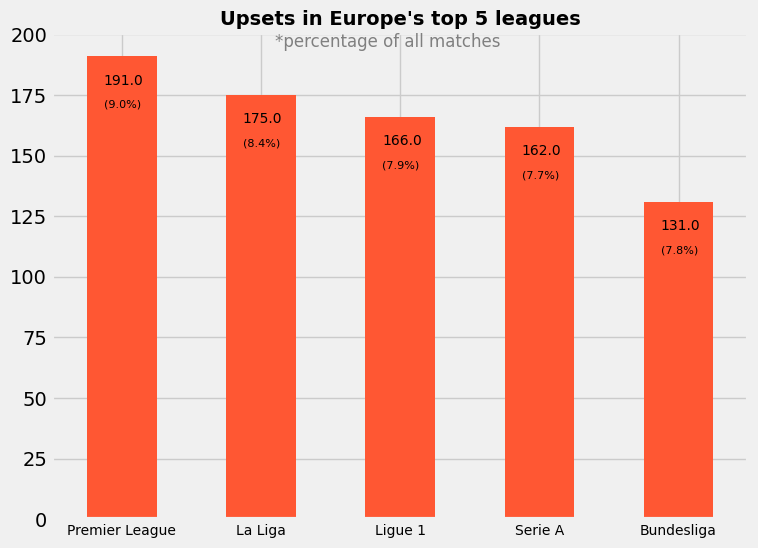

In [25]:
ax = upsets_reindexed["count"].plot(kind="bar",
                                   color="#FF5733",
                                   figsize=(8, 6))

for idx, (index, row) in enumerate(upsets_reindexed.iterrows()):
    plt.text(idx - 0.13, row['count'] - 10, f"{row['count']}", color='black', ha='left', va='center', fontsize=10)
    plt.text(idx + 0.14, row['count'] - 20, f"({row['ratio']}%)", color='black', ha='right', va='center', fontsize=8)


plt.xticks(rotation=0,fontsize=10)
plt.xlabel('')
plt.title("Upsets in Europe's top 5 leagues", fontsize=14, weight='bold')
plt.suptitle("*percentage of all matches", fontsize=12, y=0.88, color='gray')
plt.show()

As expected, the Premier League recorded the highest number of unexpected victories, with 9% of matches resulting in upsets. It's known for being the most thrilling league, though the other four leagues aren't trailing by much.

# Section 2: Teams  
In this section, I will examine various statistics for the teams and compare their performances against one another.

#### Maximizing Opportunities  
Generating numerous chances is meaningless if most are squandered. Let’s kick off this section of the report by identifying the most efficient teams across Europe’s top five leagues.

In [26]:
shots = events[events['event_type'] == 1][['event_team', 'league']].value_counts().reset_index(name="total_shots")
shots.head()

,event_team,league,total_shots
0,Real Madrid,La Liga,1637
1,Manchester City,Premier League,1636
2,Napoli,Serie A,1624
3,Liverpool,Premier League,1603
4,Tottenham,Premier League,1576


In [27]:
goals = events[events['is_goal']]["event_team"].value_counts().reset_index(name="total_goals")

In [28]:
goals.head()

,event_team,total_goals
0,Barcelona,262
1,Real Madrid,259
2,Paris Saint-Germain,221
3,Manchester City,197
4,Bayern Munich,195


In [29]:
goals_table = pd.merge(shots, goals,how='left', on='event_team')

In [30]:
teams = ["Barcelona", "Paris Saint-Germain", "Real Madrid", "AS Monaco", 
         "RB Leipzig", "Valencia", "Sevilla", "Atletico Madrid", 
         "Bayern Munich", "Hertha Berlin"]

team_abrev = {
    "Barcelona": "BAR",
    "Paris Saint-Germain": "PSG",
    "Real Madrid": "RM",
    "AS Monaco": "ASM",
    "RB Leipzig": "RBL",
    "Valencia": "VAL",
    "Sevilla": "SEV",
    "Atletico Madrid": "ATM",
    "Bayern Munich": "BAY",
    "Hertha Berlin": "HER"
}

In [31]:
goals_table["goals_per_shot"] = goals_table["total_goals"] / goals_table["total_shots"]
goals_table = goals_table.sort_values("goals_per_shot", ascending=False).head(10)
goals_table["league"] = goals_table['league'].astype('str')

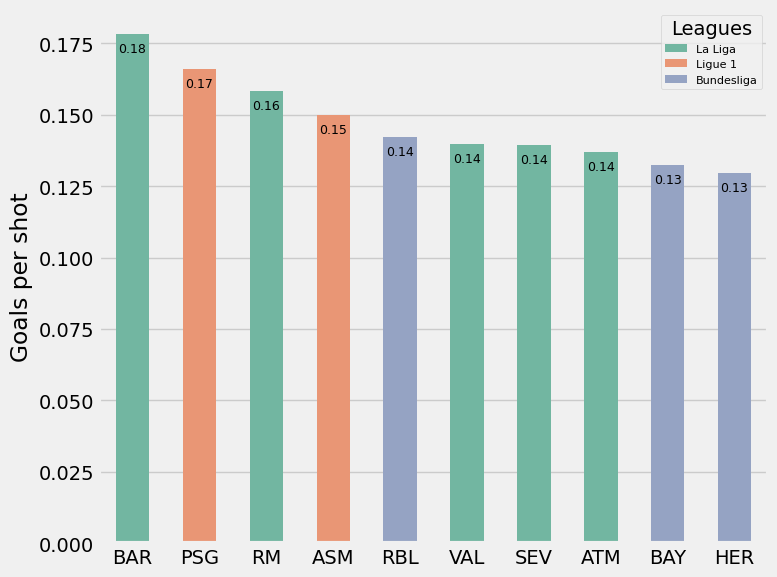

In [32]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=goals_table, x="event_team", y="goals_per_shot",hue="league",width = 0.5, palette='Set2')

for idx, value in enumerate(goals_table["goals_per_shot"]):
    plt.text(idx - 0.21, value - 0.005, f"{round(value,2)}", color='black', ha='left', va='center', fontsize=9)

plt.xticks(ticks=range(len(goals_table.event_team)), labels=list(team_abrev.values()))
plt.xlabel('')
plt.ylabel('Goals per shot')
plt.legend(title="Leagues", loc='upper right', fontsize=8, title_fontsize='medium', frameon=True)
plt.tight_layout()
plt.show()

Barcelona stands out as the most efficient team, scoring roughly once every five shots. Interestingly, no teams from the Premier League or Serie A make the top ten. This could suggest a combination of stronger goalkeeping or less effective finishing in those leagues.

### Wrong Sport, Lads!  
Unless you're the goalkeeper (or channeling Maradona), handling the ball is a big no-no in football. So, which teams seem to be ignoring this rule the most?

In [33]:
#event type : 
# 10 : Hand ball

In [34]:
handballs = events[events["event_type"] == 10]
handballs = handballs[["event_team","league"]].value_counts().reset_index(name="count").sort_values(["league","count"],ascending=[True, False])

In [35]:
handballs = handballs.groupby('league').head(4)

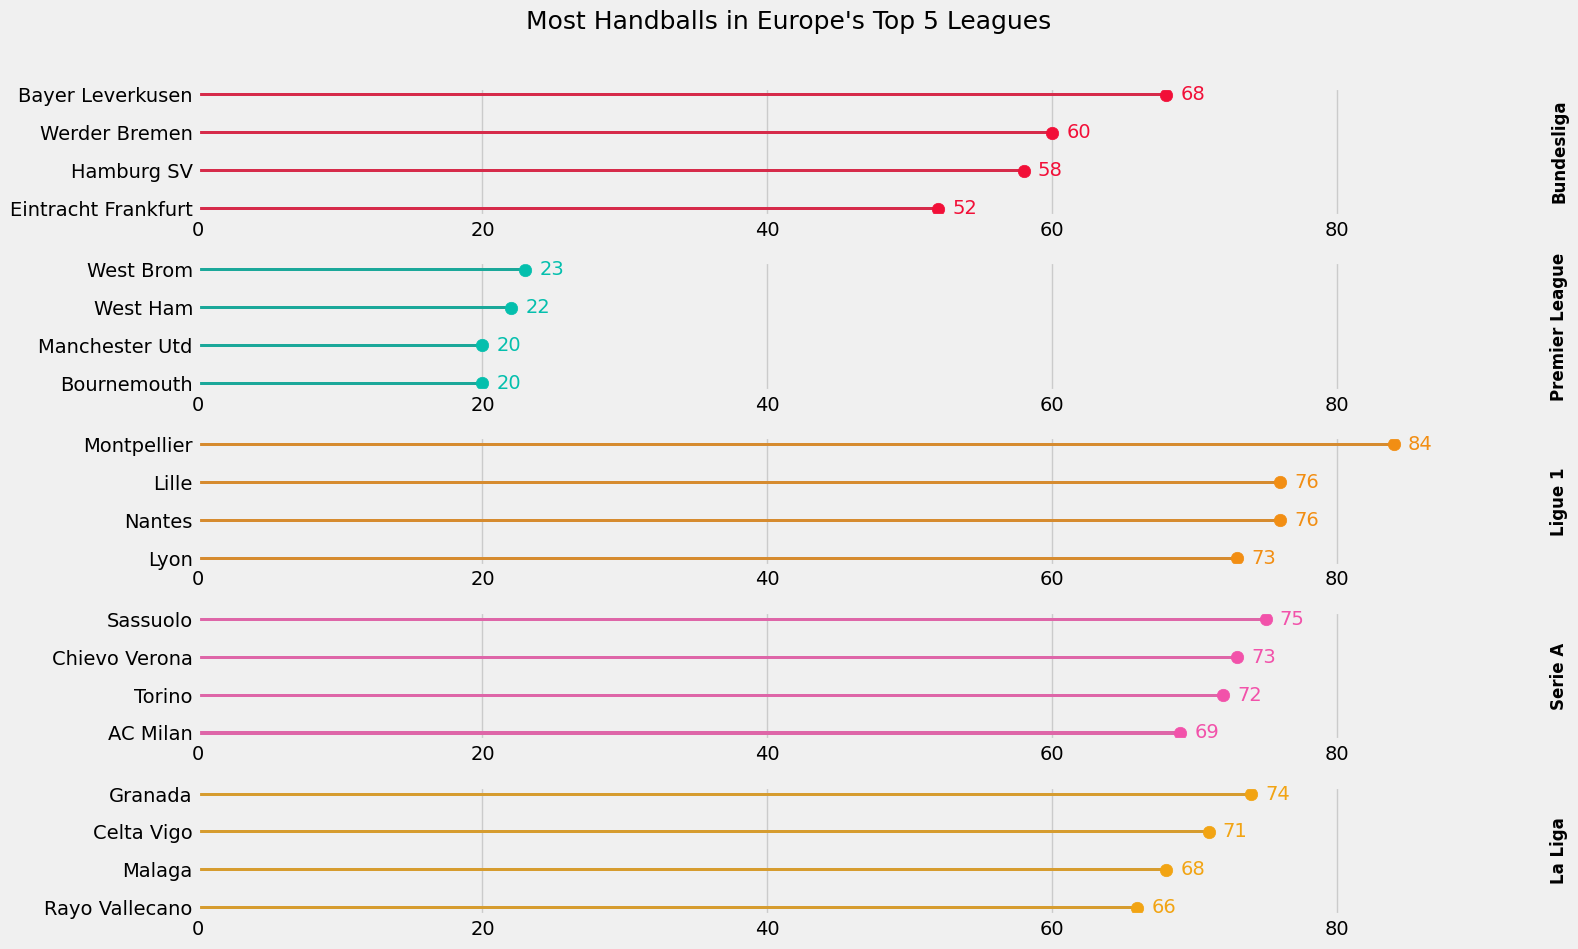

In [36]:
# Iterate over each league and plot individually using facet-like behavior
leagues = handballs['league'].unique()
x_max = handballs['count'].max() + 10 

color_list = ["#F20F38","#04BFAD","#F28E13","#F252AA","#F2A413"]

# Create subplots with a row for each league
fig, axes = plt.subplots(nrows=len(leagues), ncols=1, figsize=(16, 10), sharex=False)


for i, league in enumerate(leagues):
    league_data = handballs[handballs['league'] == league]

    # Plot teams for each league
    sns.barplot(data=league_data, x='count', y='event_team', color=color_list[i], width=0.08, ax=axes[i])
    axes[i].set_ylabel(league, fontsize=12, labelpad=10, fontweight="bold")
    axes[i].yaxis.set_label_position("right")
    axes[i].set(xlabel='')
    axes[i].set_xlim(0, x_max)  
    axes[i].set_xticks(range(0, int(x_max), 20))


    # Plot the points  
    for j in range(len(league_data)):
        axes[i].text(league_data['count'].iloc[j] + 1, j, str(league_data['count'].iloc[j]), 
                    color=color_list[i], va='center')
        axes[i].scatter(league_data['count'].iloc[j] , j, color=color_list[i], s=80)


fig.suptitle("Most Handballs in Europe's Top 5 Leagues", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])


This plot reveals that the Premier League records significantly fewer handballs compared to the other leagues. Montpellier from France proudly holds the title for the most handballs.

### Unlucky Day  
One of the most painful experiences for any player is witnessing their shot bounce off the post. I’ll create a similar plot to determine which teams have hit the bars more often than others."


In [37]:
#shot_outcome
# 4 : 	Hit the bar


In [38]:
bars = events[events["shot_outcome"] == 4]
bars = bars[["event_team","league"]].value_counts().reset_index(name="count").sort_values(["league","count"],ascending=[True, False])

In [39]:
bars = bars.groupby('league').head(4)

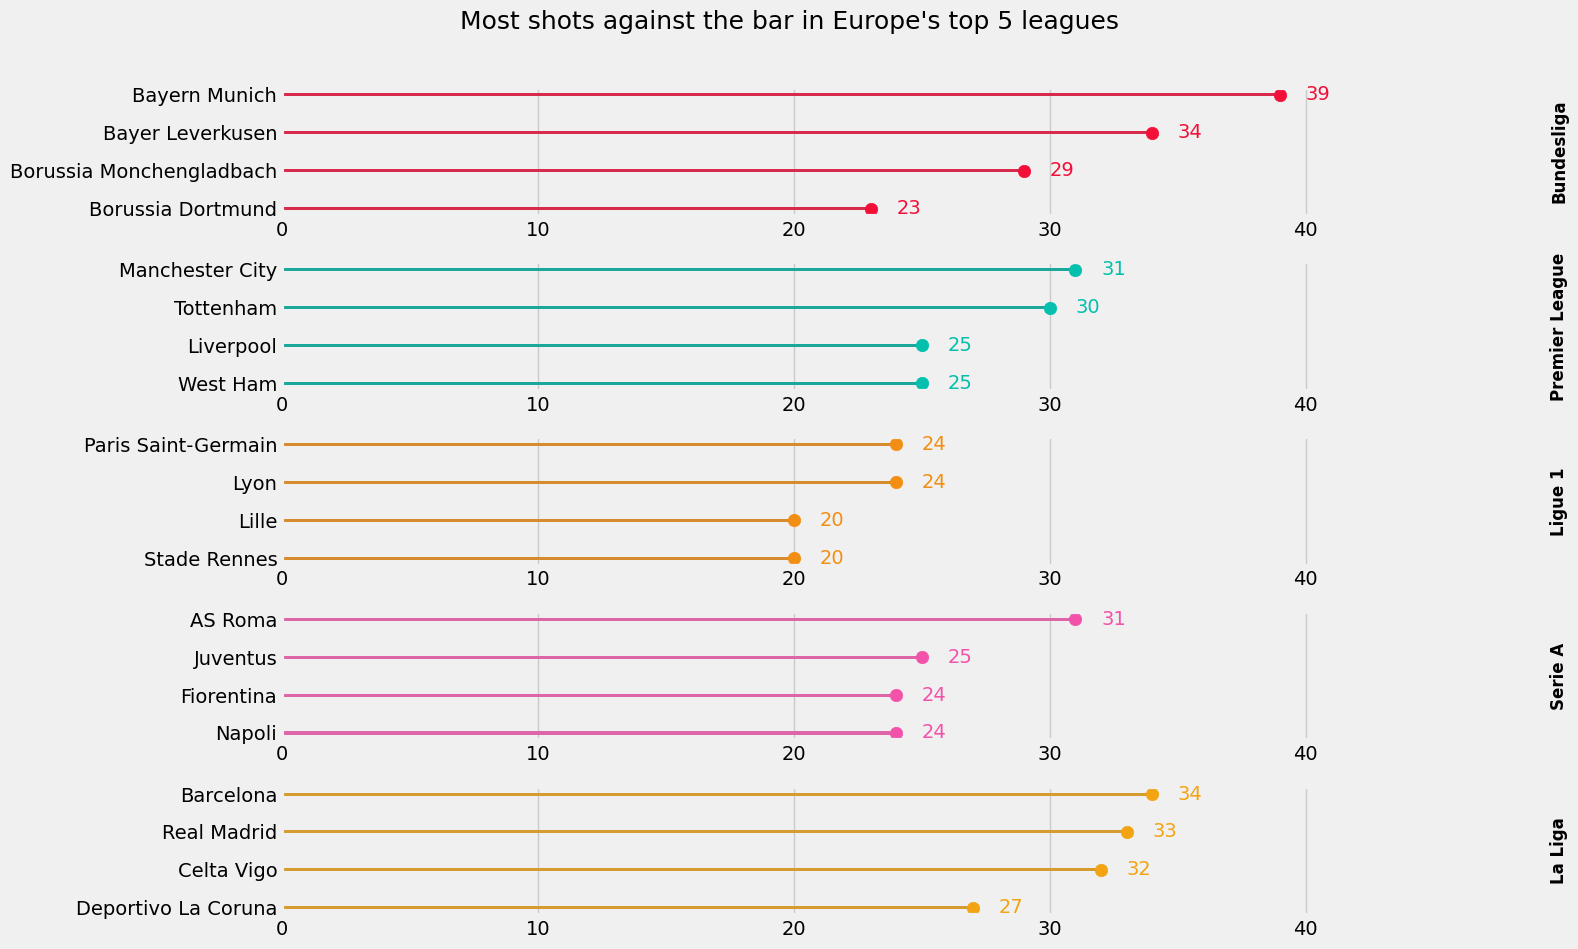

In [40]:
# Iterate over each league and plot individually using facet-like behavior
leagues = bars['league'].unique()
x_max = bars['count'].max() + 10 

color_list = ["#F20F38","#04BFAD","#F28E13","#F252AA","#F2A413"]

# Create subplots with a row for each league
fig, axes = plt.subplots(nrows=len(leagues), ncols=1, figsize=(16, 10), sharex=False)


for i, league in enumerate(leagues):
    league_data = bars[bars['league'] == league]

    # Plot teams for each league
    sns.barplot(data=league_data, x='count', y='event_team', color=color_list[i], width=0.08, ax=axes[i])
    axes[i].set_ylabel(league, fontsize=12, labelpad=10, fontweight="bold")
    axes[i].yaxis.set_label_position("right")
    axes[i].set(xlabel='')
    axes[i].set_xlim(0, x_max)  
    #axes[i].set_xticks(range(0, int(x_max), 20))


    # Plot the points  
    for j in range(len(league_data)):
        axes[i].text(league_data['count'].iloc[j] + 1, j, str(league_data['count'].iloc[j]), 
                    color=color_list[i], va='center')
        axes[i].scatter(league_data['count'].iloc[j] , j, color=color_list[i], s=80)


fig.suptitle("Most shots against the bar in Europe's top 5 leagues", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])


It seems that Bayern Munich holds the title of the unluckiest team in Europe, having struck the post an astonishing 39 times over the past few years, even with their season being four matches shorter than their non-German counterparts.

### Leaving It Late

Few moments in football are more exhilarating than scoring a last-minute winner. Let’s explore which teams have savored the most dramatic finishes. Since the dataset doesn't track the score in real-time, identifying these moments required some intricate filtering. However, thanks to an intensive amount of data filtering, I was able to significantly reduce both the complexity and runtime of the script, allowing for clearer and faster results despite the initial challenge.



In [107]:
# Filter 1: No draw games, create a list of indexes
no_draw_games_indexes = matches[matches["fthg"] != matches["ftag"]].set_index('id_odsp').index

# Filter 2: Retrieve the corresponding dataframe from the "events" DataFrame using this mask
no_draw_events = events[events.set_index('id_odsp').index.isin(no_draw_games_indexes)]

# Filter 3: Filter for late goals in each game, where goals were scored after the 85th minute
late_goals = no_draw_events[(no_draw_events['is_goal']) & (no_draw_events['time'] >= 85)]


# Groups the late goals by id_odsp (game ID) and retrieves the row with the maximum sort order (last goal) for each game.
max_values = late_goals.groupby("id_odsp")["sort_order"].max().reset_index()

# Use the identified indices as a mask to filter the original dataframe and retrieve the corresponding rows
late_goals =  late_goals[late_goals.set_index(['id_odsp', 'sort_order']).index.isin(max_values.set_index(['id_odsp', 'sort_order']).index)]

This code applies the following steps:

**Filter 1 :** Selects the games where there was no draw `(fthg != ftag)`, and creates a list of game indices.\
**Filter 2 :** Retrieves the corresponding rows from the events DataFrame based on these indices `(no_draw_events)`.\
**Filter 3 :** Filters `no_draw_events` to select goals scored after the 85th minute `(late_goals)`.\
**Grouping :** Groups the late goals by `id_odsp` (game ID) and selects the row with the highest `sort_order` (i.e., the last goal in each game), ensuring that goals scored in the same minute of the match are filtered out based on their sequential order rather than just the time.\
**Filter 4 :** Filtering based on `Max Values` a filtered set of indices to extract the relevant rows from `late_goals`.

**Row Counting:** Prints the count of rows before and after the filters are applied for comparison.

In [113]:
# Count rows before and after applying advanced filters
late_goals_no_adv_Filters = events[(events["time"] >= 85) & events.is_goal]
print("Late_goals DF row count without advanced filters :" ,late_goals_no_adv_Filters.shape[0])
print("Late_goals DF row count after advanced filters   :" ,late_goals.shape[0])


# Filtered events after removing draw games and selecting goals events only
goals_events = no_draw_events[(no_draw_events['is_goal'])]
print("\nEvents DF row count without advanced filters     :", events.shape[0])
print("Events DF row count after advanced filters       :", goals_events.shape[0])

Late_goals DF row count without advanced filters : 1474
Late_goals DF row count after advanced filters   : 1073

Events DF row count without advanced filters     : 459634
Events DF row count after advanced filters       : 9821


In [114]:
# Filter out all goal events from no_draw_events 
goals_events = no_draw_events[(no_draw_events['is_goal'])]

# Initialize list to store positions of late winners
winners = []

# Iterate through each late goal
for i in range(len(late_goals)):
    # Get the order and game ID of the current late goal
    t = late_goals.iloc[i]['sort_order']
    last_goal_id = late_goals.iloc[i]['id_odsp']
    
    # Filter match events before this late goal
    match_events_before_goal = goals_events[(goals_events['id_odsp'] == last_goal_id) & (goals_events['sort_order'] < t)]
    
    # Check if the score was tied before the goal (equal number of goals for both sides)
    if (len(match_events_before_goal[match_events_before_goal['side'] == 1]) == 
        len(match_events_before_goal[match_events_before_goal['side'] == 2])) :
        winners.append(i)

# Filter late winners from the late_goals DataFrame
late_winners = late_goals.iloc[winners].groupby(['event_team', 'league']).size().reset_index(name='wins_count')

# Sort and retrieve the top 23 teams
late_winners = late_winners.sort_values(by='wins_count',ascending=False).head(23)

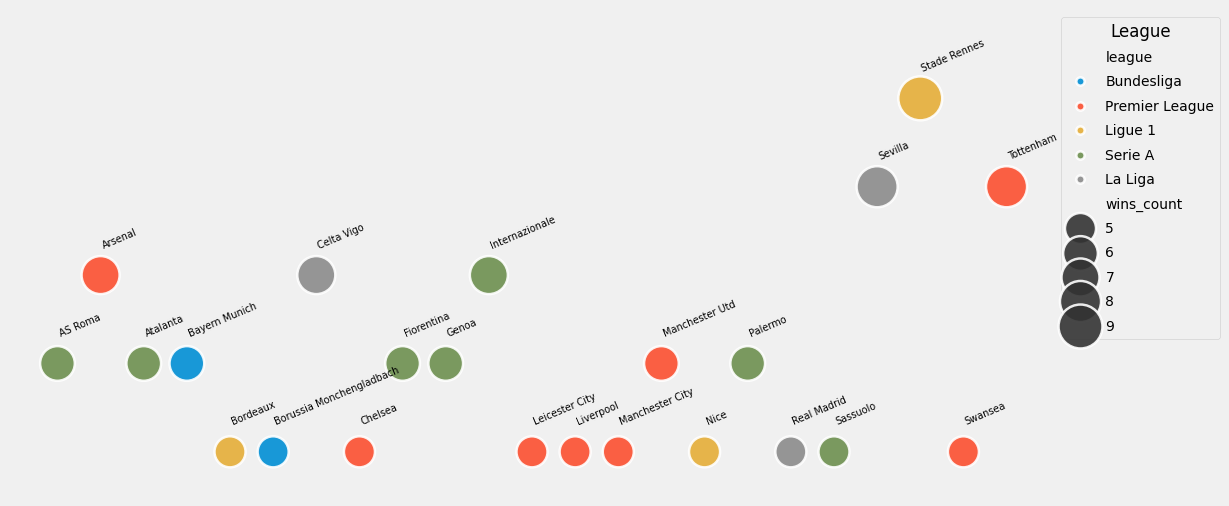

In [245]:
plt.figure(figsize=(12, 6))

# Create a scatter plot with jitter
sns.scatterplot(
    data=late_winners.sort_values('event_team'), 
    x='event_team', 
    y='wins_count', 
    hue='league', 
    size='wins_count', 
    sizes=(500, 1000),  # Adjusting the size range for visibility
    alpha=0.9, 
    #edgecolor='black',
    legend=True
)

for i in range(len(late_winners)):
    plt.text(
        x=late_winners['event_team'].iloc[i], 
        y=late_winners['wins_count'].iloc[i] + 0.3, 
        s=late_winners['event_team'].iloc[i], 
        fontsize=7, 
        rotation = 23,
        ha='left'
    )


# Remove the axis labels and ticks
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.ylim(4.5, 10)
plt.legend( bbox_to_anchor=(1, 1), 
           title='League', markerscale=1, 
           fontsize=10, title_fontsize=12, 
           frameon=True,labelspacing=0.75)

plt.show()

Based on this bubble plot, Tottenham, Sevilla, and Rennes emerge as the kings of last-minute winners, with Rennes recording 9 such goals over this time period, while Tottenham and Sevilla each have 8. The English and Italian teams, in particular, show incredible fighting spirit, making up 70% of the teams in the plot.

# Section 3: Players
In this section, we'll spotlight some of the standout performers in European football. This will be the concluding part of the report.


### Can’t Stop Scoring
Let's begin by examining the sport's most prolific goalscorers. It's important to note that this dataset focuses solely on statistics from domestic leagues and excludes goals scored in the UEFA Champions League or cup competitions.



In [328]:
top_goalscorers = events_goals.groupby('player').size().reset_index(name="goals").sort_values("goals", ascending=False).head(25)

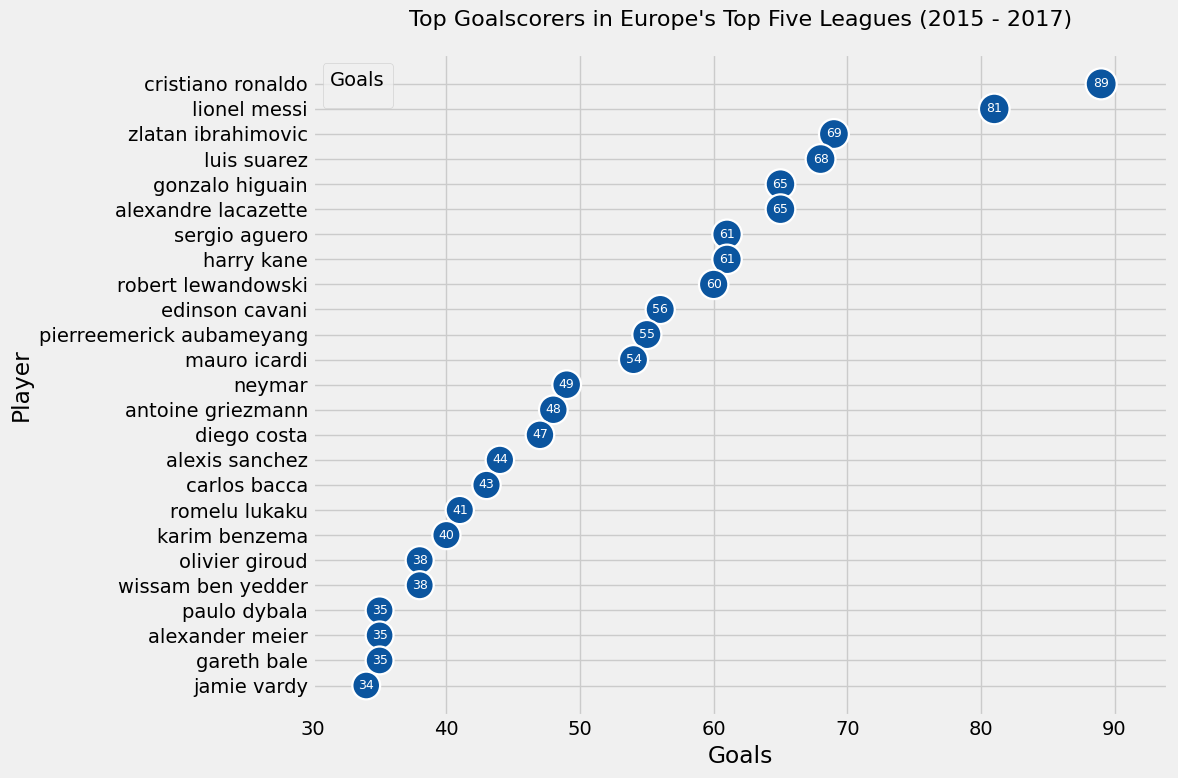

In [329]:
dark_blue_palette = sns.color_palette("Blues")[5:] # Remove the lightest shades
plt.figure(figsize=(12, 8))

sns.scatterplot(data=top_goalscorers, x='goals', y='player', size='goals', hue='goals', palette=dark_blue_palette, sizes=(400, 500),legend=False)

# Add labels
for i in range(len(top_goalscorers)):
    plt.text(top_goalscorers['goals'].iloc[i], i, str(top_goalscorers['goals'].iloc[i]), color='white', ha='center', va='center', fontsize=9)

# Title and aesthetic adjustments
plt.title("Top Goalscorers in Europe's Top Five Leagues (2015 - 2017)", fontsize=16, pad=20)
plt.xlabel('Goals')
plt.ylabel('Player')
plt.xlim(30, top_goalscorers['goals'].max() + 5)  # Adjust the x-limit for padding
plt.legend(title='Goals')
plt.tight_layout()
plt.show()

It’s no shocker that Ronaldo and Messi lead the pack, towering over the rest of Europe’s top scorers. After all, they’ve been at the pinnacle of world football for years. Interestingly, La Liga boasts seven players in the top 25 goalscorers in Europe—more than any other league. Now, let’s dive deeper and see how the leagues compare in terms of top scorers.

In [342]:
top_goalscorers = events_goals.groupby(["league","player"]).size().reset_index(name='goals').sort_values("goals", ascending=False)

top_goalscorers = top_goalscorers.groupby('league').head(4)

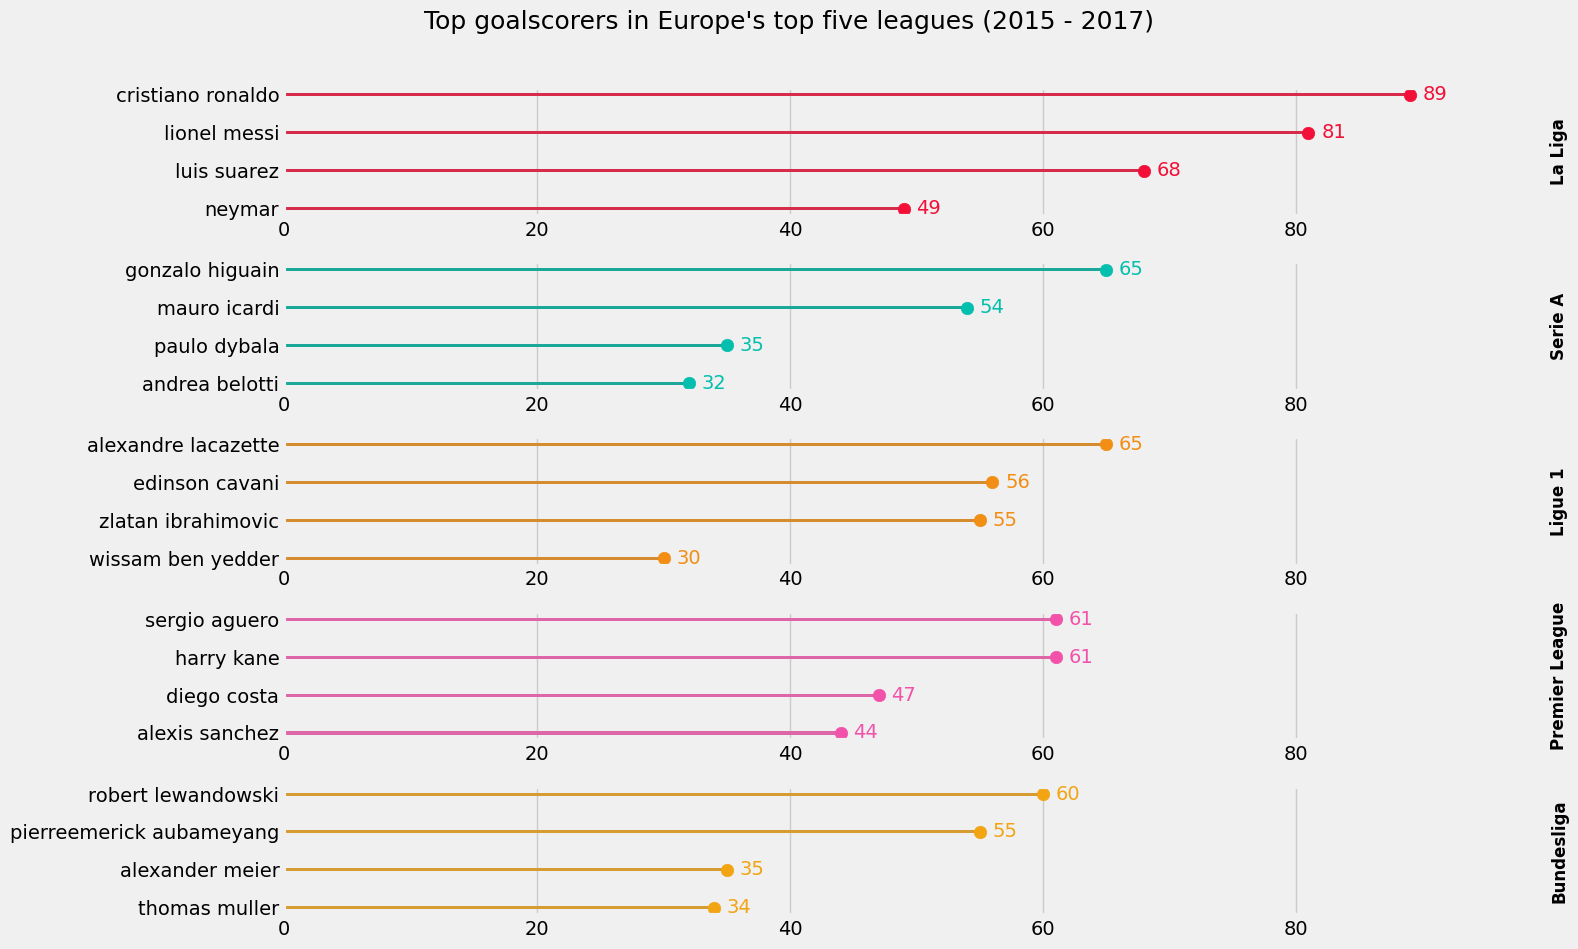

In [347]:

# Iterate over each league and plot individually using facet-like behavior
leagues = top_goalscorers['league'].unique()
x_max = top_goalscorers['goals'].max() + 10 

color_list = ["#F20F38","#04BFAD","#F28E13","#F252AA","#F2A413"]

# Create subplots with a row for each league
fig, axes = plt.subplots(nrows=len(leagues), ncols=1, figsize=(16, 10), sharex=False)


for i, league in enumerate(leagues):
    league_data = top_goalscorers[top_goalscorers['league'] == league]

    # Plot teams for each league
    sns.barplot(data=league_data, x='goals', y='player', color=color_list[i], width=0.08, ax=axes[i])
    axes[i].set_ylabel(league, fontsize=12, labelpad=10, fontweight="bold")
    axes[i].yaxis.set_label_position("right")
    axes[i].set(xlabel='')
    axes[i].set_xlim(0, x_max)  
    #axes[i].set_xticks(range(0, int(x_max), 20))


    # Plot the points  
    for j in range(len(league_data)):
        axes[i].text(league_data['goals'].iloc[j] + 1, j, str(league_data['goals'].iloc[j]), 
                    color=color_list[i], va='center')
        axes[i].scatter(league_data['goals'].iloc[j] , j, color=color_list[i], s=80)


fig.suptitle("Top goalscorers in Europe's top five leagues (2015 - 2017)", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])


Serie A exhibited the largest gap between the top scorer and the second-highest goalscorer, with Juventus's Higuain enjoying a comfortable lead of 11 goals. In contrast, the Premier League is experiencing a fierce competition, as both Aguero and Kane are tied at 61 goals each. Next, let’s analyze the top goalscorers by their scoring methods: headers, left foot, or right foot.

In [453]:
top_goalscorers = events_goals.groupby(["bodypart","player"]).size().reset_index(name='goals').sort_values("goals", ascending=False)
top_goalscorers = top_goalscorers.groupby('bodypart').head(5).sort_values("bodypart")


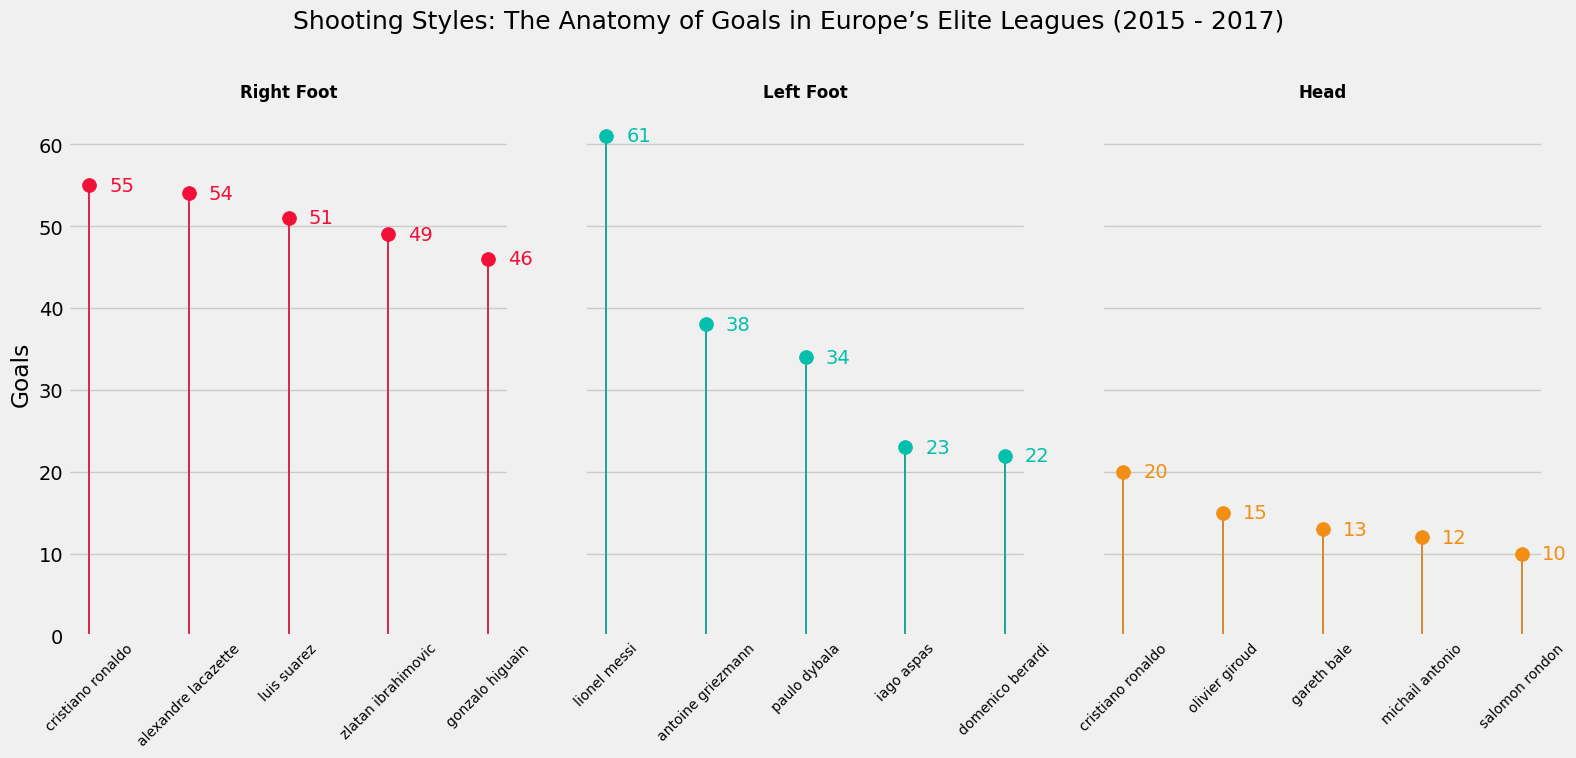

In [451]:
bodyparts = top_goalscorers['bodypart'].unique()

body_mapper = {1: "Right Foot", 
               2: "Left Foot", 
               3: "Head"}

color_list = ["#F20F38","#04BFAD","#F28E13"]

# Create subplots with a row for each league
fig, axes = plt.subplots(nrows=1, ncols= len(bodyparts), figsize=(16, 8), sharex=False, sharey=True)


for i, bodypart in enumerate(bodyparts):
    body_data = top_goalscorers[top_goalscorers['bodypart'] == bodypart]

    # Plot teams for each league
    sns.barplot(data=body_data, x='player', y='goals', color=color_list[i], width=0.02 , ax=axes[i])
    axes[i].set_xlabel(body_mapper[bodypart], fontsize=12, labelpad=10, fontweight="bold")
    axes[i].xaxis.set_label_position("top")
    axes[i].set(ylabel='Goals')
    axes[i].set_xticklabels(body_data.player,rotation=45, fontsize=10)  
    

    # Plot the points  
    for j in range(len(body_data)):
        axes[i].text(j+0.2, body_data['goals'].iloc[j], str(body_data['goals'].iloc[j]), 
                    color=color_list[i], va='center')
        axes[i].scatter(j, body_data['goals'].iloc[j] , color=color_list[i], s=100)


fig.suptitle("Shooting Styles: The Anatomy of Goals in Europe’s Elite Leagues (2015 - 2017)", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

Cristiano Ronaldo makes two appearances on this list, showcasing his prowess as the top scorer for both headers and right-footed shots. Unsurprisingly, Lionel Messi reigns supreme in the left-footed goals category, with no one coming close to matching his remarkable tally.